<a href="https://colab.research.google.com/github/DK257/Machine-Learning/blob/main/Soil_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/DK257/Machine-Learning

Cloning into 'Machine-Learning'...
remote: Enumerating objects: 825, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 825 (delta 1), reused 111 (delta 1), pack-reused 714
Receiving objects: 100% (825/825), 99.96 MiB | 30.97 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (1656/1656), done.


In [3]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [4]:
os.chdir("Machine-Learning")

In [5]:
#Define image size and batch size
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

#Define directories for training and validation data
TRAIN_DIR = '/content/Machine-Learning/train'
VAL_DIR = '/content/Machine-Learning/test'

In [6]:
# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="categorical",
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    label_mode="categorical",
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 1215 files belonging to 4 classes.
Found 340 files belonging to 4 classes.


In [7]:
# Class names
class_names = train_ds.class_names
print(class_names)

['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


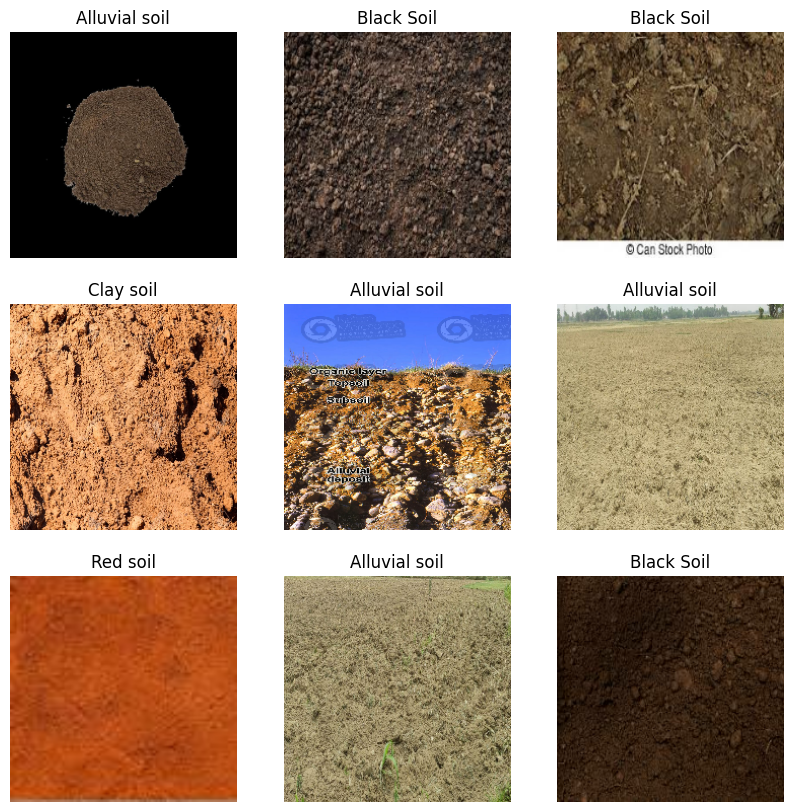

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")

In [9]:
# Define data augmentation and normalization layers
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
])

In [10]:
# Apply augmentation and normalization to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
# Select pre-trained model from TensorFlow Hub
model_handle = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [12]:
#Build the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [13]:
model.build((None,) + IMG_SIZE + (3,))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
 dense (Dense)               (None, 4)                 4008      
                                                                 
Total params: 3544273 (13.52 MB)
Trainable params: 4008 (15.66 KB)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


In [15]:
#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
76/76 [==============================] - 86s 1s/step - loss: 1.5560 - accuracy: 0.4189 - val_loss: 1.6661 - val_accuracy: 0.3588
Epoch 2/10
76/76 [==============================] - 85s 1s/step - loss: 1.0104 - accuracy: 0.5885 - val_loss: 1.3028 - val_accuracy: 0.4706
Epoch 3/10
76/76 [==============================] - 71s 918ms/step - loss: 0.8281 - accuracy: 0.6691 - val_loss: 1.1368 - val_accuracy: 0.5294
Epoch 4/10
76/76 [==============================] - 83s 1s/step - loss: 0.7277 - accuracy: 0.7152 - val_loss: 0.9802 - val_accuracy: 0.6147
Epoch 5/10
76/76 [==============================] - 77s 1s/step - loss: 0.6406 - accuracy: 0.7531 - val_loss: 0.9301 - val_accuracy: 0.6147
Epoch 6/10
76/76 [==============================] - 78s 1s/step - loss: 0.5699 - accuracy: 0.7844 - val_loss: 0.8426 - val_accuracy: 0.6794
Epoch 7/10
76/76 [==============================] - 88s 1s/step - loss: 0.5264 - accuracy: 0.8123 - val_loss: 0.7892 - val_accuracy: 0.6765
Epoch 8/10
76/76 

In [19]:
model.save("soil_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
new_model = tf.keras.models.load_model("soil_model.h5", custom_objects={'KerasLayer': hub.KerasLayer})

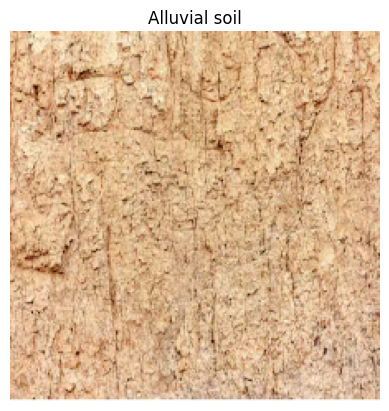

1/1 [==============================] - 1s 603ms/step
True label: Alluvial soil
Predicted label: Alluvial soil


In [21]:
#Sample Prediction
for images, labels in val_ds.take(1):
    image = images[0]
    true_label = class_names[tf.argmax(labels[0])]
    plt.imshow(image.numpy())
    plt.title(true_label)
    plt.axis("off")
    plt.show()

    # Predict the class
    image = np.expand_dims(image, axis=0)  # Expand dimensions to (1, 224, 224, 3)
    prediction = new_model.predict(image)
    predicted_label = class_names[np.argmax(prediction)]
    print(f"True label: {true_label}")
    print(f"Predicted label: {predicted_label}")

In [22]:
#Evaluate model on val_ds
eval_results = model.evaluate(val_ds)

#Show Evaluation
print("Validation Loss:", eval_results[0])
print("Validation Accuracy:", eval_results[1])

22/22 [==============================] - 11s 422ms/step - loss: 0.6575 - accuracy: 0.7294
Validation Loss: 0.6575419306755066
Validation Accuracy: 0.729411780834198
